### U-Net Nuclei masks EDA
#### Part of Kaggle's 2018 Data Sciene Bowl
- https://www.kaggle.com/c/data-science-bowl-2018

#### Spot Nuclei. Speed Cures.

Imagine speeding up research for almost every disease, from lung cancer and heart disease to rare disorders. The 2018 Data Science Bowl offers our most ambitious mission yet: create an algorithm to automate nucleus detection.

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Think how many lives would be transformed if cures came faster.

By automating nucleus detection, you could help unlock cures faster—from rare disorders to the common cold. Want a snapshot about the 2018 Data Science Bowl? [View this video.](https://www.youtube.com/watch?v=eHwkfhmJexs&feature=youtu.be)

- Alot of the work in this notework was provided by Kjetil Åmdal-SævikKeras who made the "U-Net starter - LB 0.277" the top rated Kernel on Kaggle.
- https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

In [1]:
import os
import sys
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './U_NET/train/'
TEST_PATH = './U_NET/validation/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.
/Users/loctv/miniconda3/envs/cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/loctv/miniconda3/envs/cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/loctv/miniconda3/envs/cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/loctv/miniconda3/envs/

#### Collect our file names for training and test date

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

#### Creating our image masks of dimension 128 x 128 (black images)

In [3]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
# Re-sizing our training images to 128 x 128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|██████████| 670/670 [07:26<00:00,  1.50it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 23.72it/s]

Done!


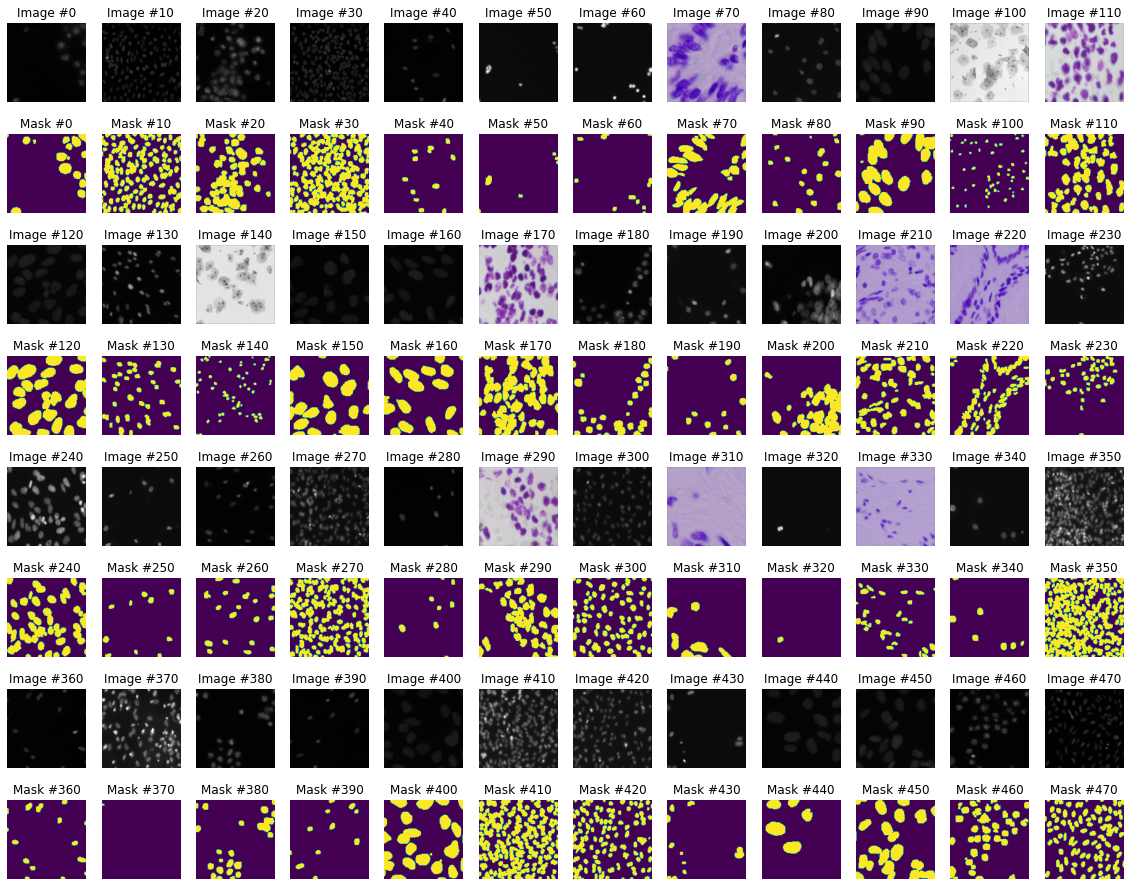

In [4]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

### We define a custom Metric called Intersection over Union (IoU)

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
# Alternative IoU function
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/51553
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection)
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

#### Another IoU Metric  
- https://www.kaggle.com/aglotero/another-iou-metric

In [7]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

### Building our U-Net Model

In [8]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________

### Fit our model

In [9]:
# Initialize our callbacks
model_path = "../Trained Models/nuclei_finder_unet_1.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Fit our model 
results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16, epochs=10, 
                    callbacks=[earlystop, checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 70s 117ms/step - loss: 0.4292 - my_iou_metric: 0.0532 - val_loss: 0.2087 - val_my_iou_metric: 0.1889

Epoch 00001: val_loss improved from inf to 0.20866, saving model to ../Trained Models/nuclei_finder_unet_1.h5
Epoch 2/10
603/603 [==============================] - 77s 127ms/step - loss: 0.1863 - my_iou_metric: 0.2458 - val_loss: 0.2629 - val_my_iou_metric: 0.2879

Epoch 00002: val_loss did not improve from 0.20866
Epoch 3/10
603/603 [==============================] - 74s 122ms/step - loss: 0.1384 - my_iou_metric: 0.3694 - val_loss: 0.2436 - val_my_iou_metric: 0.3551

Epoch 00003: val_loss did not improve from 0.20866
Epoch 4/10
603/603 [==============================] - 74s 123ms/step - loss: 0.1325 - my_iou_metric: 0.4045 - val_loss: 0.1585 - val_my_iou_metric: 0.3867

Epoch 00004: val_loss improved from 0.20866 to 0.15845, saving model to

### Generating our predictions for training and validation data

In [10]:
# Predict on training and validation data
# Note our use of mean_iou metri
model = load_model('../Trained Models/nuclei_finder_unet_2.h5', 
                   custom_objects={'my_iou_metric': my_iou_metric})

# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

67/67 [==============================] - 2s 33ms/step


### Showing our predicted masks on our training data

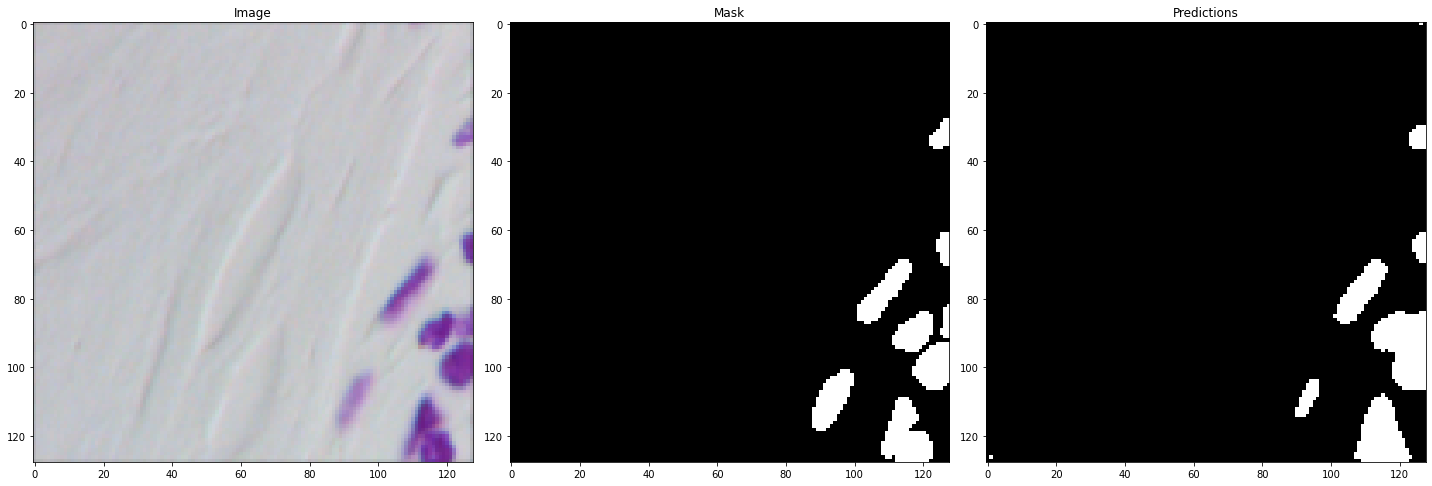

In [11]:
# Ploting our predicted masks
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

### Showing our predicted masks on our validation data

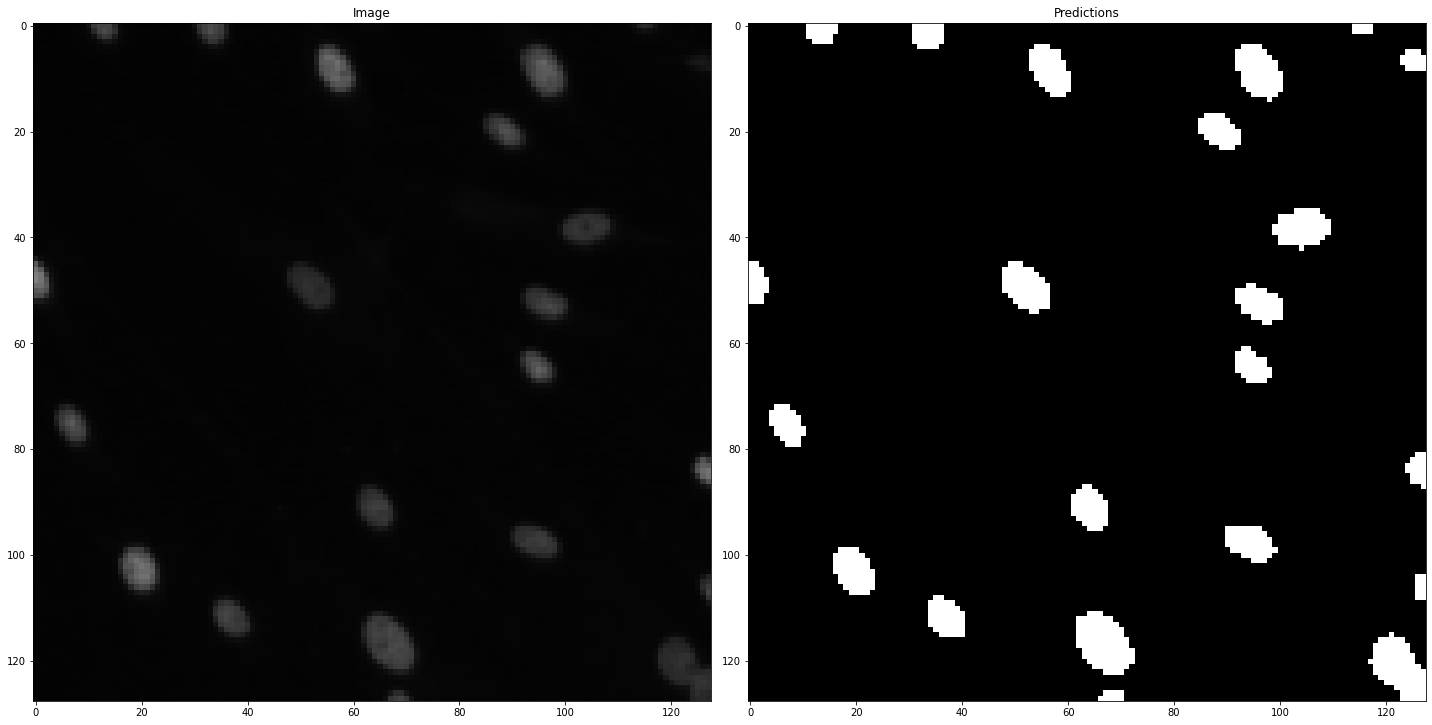

In [12]:
# Ploting our predicted masks
ix = random.randint(602, 668)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

### Generating a Classification Report

In [13]:
iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	20	5	4	0.690
0.550	20	5	4	0.690
0.600	20	5	4	0.690
0.650	19	6	5	0.633
0.700	17	8	7	0.531
0.750	16	9	8	0.485
0.800	15	10	9	0.441
0.850	6	19	18	0.140
0.900	3	22	21	0.065
0.950	0	25	24	0.000
AP	-	-	-	0.436


0.43643260810367107